## packages

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy import stats
import datetime
import gsw
import matplotlib.dates as mdates
import matplotlib.ticker as tick
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec
%matplotlib inline
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
import matplotlib.collections as collections
# from numpy.fft import fft, ifft, fftshift, fftfreq
import pywt
from scipy import signal
import matplotlib as mpl
from scipy.interpolate import griddata

from sklearn.linear_model import LinearRegression

In [3]:
from __future__ import division
import pycwt as wavelet
from pycwt.helpers import find

## funciones

In [4]:
def to_data(date,da,s,temp):
    x = pd.DataFrame({'Datetime': pd.to_datetime(date, format='%d-%b-%Y %H:%M:%S'), 'Depth': da[:,0], 'Salinity': s[:,0], 'Temperature': temp[:,0]})
    x = x.set_index('Datetime')
    return x  

In [5]:
def to_density(z, sal, temp, lat):
    p = gsw.p_from_z(-z, lat)
    rho = gsw.rho_t_exact(sal, temp, p)
    return rho

In [6]:
def earth_to_uv(dfe, dfn, a): 
    "This takes 2 dataframes of east and north coordinates respectively and the regresion coeficient and transforms them to the direction of the coeficient"
    alpha = np.arctan(a) #Ángulo
    t, b = dfe.shape 
    M = np.array([[-np.cos(alpha), np.sin(alpha)],
                  [np.sin(alpha), np.cos(alpha)]]) #Matriz de transfomación
    columns = dfe.columns
    u = np.zeros((0,t)) #Inicialización de variables
    v = np.zeros((0,t)) #Inicialización de variables
    for i in columns: #Iteración sobre las columnas de los dataframes
        bin_ = np.array([[dfe[i].values],
                        [dfn[i].values]]) # Matriz de coordenadas east-north
        ui, vi = np.tensordot(M, bin_, 1) #Multiplicación matricial
        u = np.concatenate((u, ui), axis=0) #Unión de los resultados de u
        v = np.concatenate((v, vi), axis=0)#Unión de los resultados de v
    return u, v

In [7]:
def spectrum1(h, dt=1):
    """
    First cut at spectral estimation: very crude.
    
    Returns frequencies, power spectrum, and
    power spectral density.
    Only positive frequencies between (and not including)
    zero and the Nyquist are output.
    """
    nt = len(h)
    npositive = nt//2
    pslice = slice(1, npositive)
    freqs = np.fft.fftfreq(nt, d=dt)[pslice] 
    ft = np.fft.fft(h)[pslice]
    psraw = np.abs(ft) ** 2
    # Double to account for the energy in the negative frequencies.
    psraw *= 2
    # Normalization for Power Spectrum
    psraw /= nt**2
    # Convert PS to Power Spectral Density
    psdraw = psraw * dt * nt  # nt * dt is record length
    return freqs, psraw, psdraw

In [8]:
def spectrum2(h, dt=1, nsmooth=5):
    """
    Add simple boxcar smoothing to the raw periodogram.
    
    Chop off the ends to avoid end effects.
    """
    freqs, ps, psd = spectrum1(h, dt=dt)
    weights = np.ones(nsmooth, dtype=float) / nsmooth
    ps_s = np.convolve(ps, weights, mode='valid')
    psd_s = np.convolve(psd, weights, mode='valid')
    freqs_s = np.convolve(freqs, weights, mode='valid')
    return freqs_s, ps_s, psd_s

In [9]:
def spectrum3(h, dt=1, nsmooth=5):
    """
    Detrend first.
    """
    t = np.arange(len(h))
    p = np.polyfit(t, h, 1)
    h_detrended = h - np.polyval(p, t)
    return spectrum2(h_detrended, dt=dt, nsmooth=nsmooth)

In [10]:
def detrend(h):
    n = len(h)
    t = np.arange(n)
    p = np.polyfit(t, h, 1)
    h_detrended = h - np.polyval(p, t)
    return h_detrended
    
def quadwin(n):
    """
    Quadratic (or "Welch") window
    """
    t = np.arange(n)
    win = 1 - ((t - 0.5 * n) / (0.5 * n)) ** 2
    return win

def spectrum4(h, dt=1, nsmooth=5):
    """
    Detrend and apply a quadratic window.
    """
    n = len(h)

    h_detrended = detrend(h)
    
    winweights = quadwin(n)
    h_win = h_detrended * winweights
    
    freqs, ps, psd = spectrum2(h_win, dt=dt, nsmooth=nsmooth)
    
    # Compensate for the energy suppressed by the window.
    psd *= n / (winweights**2).sum()
    ps *= n**2 / winweights.sum()**2
    
    return freqs, ps, psd

In [11]:
def freq2period(x):
    x = x.astype(float)
    return x ** (-1) / 60


def period2freq(x):
    x = x.astype(float)
    return (x * 60) ** (-1)

In [12]:
import math

def haversine(lat1, lon1, lat2, lon2):
    rad = math.pi/180
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    R = 6372.795477598 # km radio de la tierra
    a = (math.sin(rad*dlat/2))**2 + math.cos(rad*lat1)*math.cos(rad*lat2)*(math.sin(rad*dlon/2))**2
    dist = 2*R*math.asin(math.sqrt(a))
    return dist

In [13]:
def standardize(s, detrend=True, standardize=True, remove_mean=False):
    '''
    Helper function for pre-processing data, specifically for wavelet analysis

    INPUTS:
        s - numpy array of shape (n,) to be normalized
        detrend - boolean on whether to linearly detrend s
        standardize - boolean on whether to divide by the standard deviation
        remove_mean - boolean on whether to remove the mean of s. Exclusive with detrend.

    OUTPUTS:
        snorm - numpy array of shape (n,)
    '''

    # Derive the variance prior to any detrending
    std = s.std()
    smean = s.mean()

    if detrend and remove_mean:
        raise ValueError('Only standardize by either removing secular trend or mean, not both.')

    # Remove the trend if requested
    if detrend:
        arbitrary_x = np.arange(0, s.size)
        p = np.polyfit(arbitrary_x, s, 1)
        snorm = s - np.polyval(p, arbitrary_x)
    else:
        snorm = s

    if remove_mean:
        snorm = snorm - smean

    # Standardize by the standard deviation
    if standardize:
        snorm = (snorm / std)

    return snorm

# Importar y arreglar datos

In [14]:
# feb16 = xr.open_dataset("data/adcp2012feb.nc")
# newfeb = feb16.sel(time=slice("2012-02-17","2012-03-08"))
# adcp = xr.open_dataset("C://Users//Dhannai//Documents//git//dump//adcp//data//adcp2012feb.nc")

UV_burst = xr.open_dataset("data/UV_burst.nc")
EN_burst = xr.open_dataset("data/EastNorth_burst.nc")
vert_burst = pd.read_csv('data/burst_vert.csv')

In [15]:
# adcp = xr.open_dataset("C://Users//dhann//Documents//git//dump//adcp//data//adcp2012feb.nc")
# adcp = xr.open_dataset("C://Users//Dhannai//Documents//git//dump//adcp//data//adcp2012feb.nc")

In [16]:
#Convertir velocidades a DataFrames
columnas = ['bin_1','bin_2','bin_3','bin_4','bin_5','bin_6','bin_7','bin_8','bin_9','bin_10','bin_11','bin_12','bin_13','bin_14','bin_15','bin_16','bin_17','bin_18','bin_19','bin_20','bin_21','bin_22','bin_23','bin_24','bin_25']

df_east = pd.DataFrame(EN_burst.east.values, columns = columnas)
df_east.index = EN_burst.time.values

df_north = pd.DataFrame(EN_burst.north.values, columns = columnas)
df_north.index = EN_burst.time.values

u, v = earth_to_uv(df_east, df_north, 1.13493621)

df_u = pd.DataFrame(np.transpose(u), columns = columnas)
df_u.index = EN_burst.time.values

df_v = pd.DataFrame(np.transpose(v), columns = columnas)
df_v.index = EN_burst.time.values

vert_burst.index = pd.to_datetime(vert_burst['Unnamed: 0'], format='%Y-%m-%d %H:%M:%S')
vert_burst = vert_burst.drop(['Unnamed: 0'], axis=1)

In [17]:
DC_CTD = xr.open_dataset("data//DC_CTD")
NM_CTD = xr.open_dataset("data//NM_CTD")
ML_CTD = xr.open_dataset("data//ML_CTD")
PC_CTD = xr.open_dataset("data//PC_CTD")

In [18]:
DC_CTD['v'] = DC_CTD['__xarray_dataarray_variable__']
DC_CTD = DC_CTD.drop(['__xarray_dataarray_variable__'])

NM_CTD['v'] = NM_CTD['__xarray_dataarray_variable__']
NM_CTD = NM_CTD.drop(['__xarray_dataarray_variable__'])

ML_CTD['v'] = ML_CTD['__xarray_dataarray_variable__']
ML_CTD = ML_CTD.drop(['__xarray_dataarray_variable__'])

PC_CTD['v'] = PC_CTD['__xarray_dataarray_variable__']
PC_CTD = PC_CTD.drop(['__xarray_dataarray_variable__'])

In [19]:
DC = sio.loadmat("C://Users//Dhannai//OneDrive - Universidad Técnica Federico Santa María//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//DC_ctds_localdates.mat")
NM = sio.loadmat("C://Users//Dhannai//OneDrive - Universidad Técnica Federico Santa María//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//NM_ctds_localdates.mat")
ML = sio.loadmat("C://Users//Dhannai//OneDrive - Universidad Técnica Federico Santa María//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//AC_ctds_localdates.mat")
PC = sio.loadmat("C://Users//Dhannai//OneDrive - Universidad Técnica Federico Santa María//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//PC_ctds_localdates.mat")

# DC = sio.loadmat("C://Users//dhann//OneDrive - Universidad Técnica Federico Santa María//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//DC_ctds_localdates.mat")
# NM = sio.loadmat("C://Users//dhann//OneDrive - Universidad Técnica Federico Santa María//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//NM_ctds_localdates.mat")
# ML = sio.loadmat("C://Users//dhann//OneDrive - Universidad Técnica Federico Santa María//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//AC_ctds_localdates.mat")
# PC = sio.loadmat("C://Users//dhann//OneDrive - Universidad Técnica Federico Santa María//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//PC_ctds_localdates.mat")

In [20]:
DC_1 = to_data(DC['tdate_dc1'], DC['da_dc1'], DC['s_dc1'], DC['temp_dc1'])
DC_2 = to_data(DC['tdate_dc2'], DC['da_dc2'], DC['s_dc2'], DC['temp_dc2'])
DC_3 = to_data(DC['tdate_dc3'], DC['da_dc3'], DC['s_dc3'], DC['temp_dc3'])
DC_4 = to_data(DC['tdate_dc4'], DC['da_dc4'], DC['s_dc4'], DC['temp_dc4'])

NM_1 = to_data(NM['tdate_nm1'], NM['da_nm1'], NM['s_nm1'], NM['temp_nm1'])
NM_2 = to_data(NM['tdate_nm2'], NM['da_nm2'], NM['s_nm2'], NM['temp_nm2'])
NM_3 = to_data(NM['tdate_nm3'], NM['da_nm3'], NM['s_nm3'], NM['temp_nm3'])

ML_1 = to_data(ML['tdate_ac1'], ML['da_ac1'], ML['s_ac1'], ML['temp_ac1'])
ML_2 = to_data(ML['tdate_ac2'], ML['da_ac2'], ML['s_ac2'], ML['temp_ac2'])

PC_1 = to_data(PC['tdate_pc'], PC['da_pc'], PC['s_pc'], PC['temp_pc'])

In [21]:

df2 = pd.read_table('C://Users//Dhannai//OneDrive - Universidad Técnica Federico Santa María//Documents//Magister//Estuario Pescadero//meteorological_station//raw//CR200Series_sixmin_pescadero_20120301.dat', sep=",", header=[1, 2, 3])
df2 = pd.DataFrame(df2.values, columns = ['TIMESTAMP','RECORD','Speed','Direction','Winddir_D2','airTC','RH'])
df2 = df2.set_index('TIMESTAMP')
df3 = pd.read_table('C://Users//Dhannai//OneDrive - Universidad Técnica Federico Santa María//Documents//Magister//Estuario Pescadero//meteorological_station//raw//CR200Series_sixmin_pescadero_20120419.dat', sep=",", header=[1, 2, 3])
df3 = pd.DataFrame(df3.values, columns = ['TIMESTAMP','RECORD','Speed','Direction','Winddir_D2','airTC','RH'])
df3 = df3.set_index('TIMESTAMP')
result = pd.concat([df2, df3], ignore_index=False, sort=False)
result.index = pd.to_datetime(result.index)
w = result

In [22]:
north_w = np.float64(w['Speed'])*np.sin(np.pi*np.float64(w['Direction'])/180)
east_w = np.float64(w['Speed'])*np.cos(np.pi*np.float64(w['Direction'])/180)
north_w = pd.DataFrame(data=north_w, columns=['viento'])
east_w = pd.DataFrame(data=east_w, columns=['viento'])

# uw, vw = earth_to_uv(east_w, north_w, 0.79970532) #max var viento
uw, vw = earth_to_uv(east_w, north_w, 1.13493621) #max var est


dfw = pd.DataFrame(np.transpose(np.array([uw[0,:], vw[0,:]])), columns=['u', 'v'])
dfw.index = w.index

In [23]:
#Leer datos caudal
Q = pd.read_csv("data\\febmar2012.csv")
lista_nombres= ["nan1", "fecha", "nan2", "sensor", 
                "caudal", "A"]
Q.columns=lista_nombres
Q = Q.drop(columns=['nan1', 'nan2', 'sensor', 'A']).reset_index()
Q = Q.drop(columns=['level_0', 'level_1'])
Q["fecha"] = pd.to_datetime(Q["fecha"].values)

In [24]:
#Importar caudal de pescadero cada 15 min en GMT
# https://nwis.waterservices.usgs.gov/nwis/iv/?sites=11162500&parameterCd=00060&startDT=2011-07-07T00:00:00.000-07:00&endDT=2012-07-07T23:59:59.999-07:00&siteStatus=all&format=rdb
Q = pd.read_csv("data\\caudal2012.csv", sep=';') #pies cubicos por segndo
Q = Q.drop(['5s', '15s', '14n', 'Unnamed: 6'], axis=1)
Q['index'] = pd.to_datetime(Q['20d'] + ' ' + Q['6s'], format='%d-%m-%Y %H:%M')
Q = Q.set_index('index')
Q = Q.drop(['20d', '6s'], axis=1)

Q = Q/35.3147 # metros cubicos pr segundo

In [25]:
#Importar nivel de agua cada 6 min en hora local
snfco = pd.read_csv("data/CO-OPS_9414290_met.csv")
snfco = snfco.drop(['Predicted (m)', 'Preliminary (m)'], axis=1)
snfco['index'] = pd.to_datetime(snfco['Date'] + ' ' + snfco['Time (LST/LDT)'], format='%Y-%m-%d %H:%M')
snfco = snfco.set_index('index')
snfco = snfco.drop(['Date', 'Time (LST/LDT)'], axis=1)

mnty = pd.read_csv("data/CO-OPS_9413450_met.csv")
mnty = mnty.drop(['Predicted (m)', 'Preliminary (m)'], axis=1)
mnty['index'] = pd.to_datetime(mnty['Date'] + ' ' + mnty['Time (LST/LDT)'], format='%Y-%m-%d %H:%M')
mnty = mnty.set_index('index')
mnty = mnty.drop(['Date', 'Time (LST/LDT)'], axis=1)

In [26]:
#Importar datos boya 46012 (Half moon bay)
# https://www.ndbc.noaa.gov/station_history.php?station=46012
hmoon = pd.read_csv("data/46012h2012.csv", sep=';', header=0)
hmoon = hmoon.drop(['PRES','TIDE', 'ATMP', 'WTMP','DEWP', 'VIS', 'WDI', 'R WSP', 'D GST'], axis=1)
hmoon = hmoon.drop([0], axis=0)
hmoon['index'] = pd.to_datetime(hmoon['#YY'] + '-' + hmoon['MM'] + '-' + hmoon['DD'] + ' ' + hmoon['hh'] + ':' + hmoon['mm'], format='%Y-%m-%d %H:%M')
hmoon = hmoon.set_index('index')
hmoon = hmoon.drop(['#YY', 'MM', 'DD', 'hh', 'mm'], axis=1)
hmoon['WVHT'] = hmoon['WVHT'].astype('float64')
hmoon['DPD'] = hmoon['DPD'].astype('float64')
hmoon['APD'] = hmoon['APD'].astype('float64')
hmoon['MWD'] = hmoon['MWD'].astype('float64')
hmoon = hmoon.drop([datetime.datetime(2012,2,14,19,50,0), datetime.datetime(2012,2,22,11,50,0), datetime.datetime(2012,2,23,11,50,0)], axis=0)
# WVHT: Significant wave height
# DPD: Dominant wave period (seconds) is the period with the maximum wave energy.
# APD: Average wave period (seconds) of all waves during the 20-minute period. 

In [27]:
#Importar datos de backscatter
# bks_drp = np.load("C://Users//Dhannai//Documents//git//dump//bks_drp.npy")
# bks_drp1 = np.load("C://Users//Dhannai//Documents//git//dump//bks_drp1.npy")
# bks_drp2 = np.load("C://Users//Dhannai//Documents//git//dump//bks_drp2.npy")
# bks_drp3 = np.load("C://Users//Dhannai//Documents//git//dump//bks_drp3.npy")
# bks_drp4 = np.load("C://Users//Dhannai//Documents//git//dump//bks_drp4.npy")
# bks_drp1 = np.load("data/bks_drp1.npy")
# bks_drp2 = np.load("data/bks_drp2.npy")
# bks_drp3 = np.load("data/bks_drp3.npy")
# bks_drp4 = np.load("data/bks_drp4.npy")

## Perfiles

In [28]:
p1 = pd.read_csv("data/perfil1.csv", sep=';')
p1 = p1.drop(['Conductividad', 'Presión', 'Turbidez','Conduct Especifica', 'Density anomaly', 'C'], axis=1)

## Densidad

In [29]:
rho_dc1 = to_density(DC_1['Depth'], DC_1['Salinity'], DC_1['Temperature'], 37.26)
rho_dc2 = to_density(DC_2['Depth'], DC_2['Salinity'], DC_2['Temperature'], 37.26)
rho_dc3 = to_density(DC_3['Depth'], DC_3['Salinity'], DC_3['Temperature'], 37.26)
rho_dc4 = to_density(DC_4['Depth'], DC_4['Salinity'], DC_4['Temperature'], 37.26)

DC_1['densidad'] = rho_dc1
DC_2['densidad'] = rho_dc2
DC_3['densidad'] = rho_dc3
DC_4['densidad'] = rho_dc4

In [30]:
rho_nm1 = to_density(NM_1['Depth'], NM_1['Salinity'], NM_1['Temperature'], 37.26)
rho_nm2 = to_density(NM_2['Depth'], NM_2['Salinity'], NM_2['Temperature'], 37.26)
rho_nm3 = to_density(NM_3['Depth'], NM_3['Salinity'], NM_3['Temperature'], 37.26)

NM_1['densidad'] = rho_nm1
NM_2['densidad'] = rho_nm2
NM_3['densidad'] = rho_nm3

In [31]:
rho_ml1 = to_density(ML_1['Depth'], ML_1['Salinity'], ML_1['Temperature'], 37.26)
rho_ml2 = to_density(ML_2['Depth'], ML_2['Salinity'], ML_2['Temperature'], 37.26)

ML_1['densidad'] = rho_ml1
ML_2['densidad'] = rho_ml2

In [32]:
rho_pc = to_density(PC_1['Depth'], PC_1['Salinity'], PC_1['Temperature'], 37.26)

PC_1['densidad'] = rho_pc

## Depth 2

In [33]:
z_dc1 = DC_CTD.sel(variables='Depth', sensor=1) - DC_CTD.sel(variables='Depth', sensor=1)
z_dc2 = DC_CTD.sel(variables='Depth', sensor=1) - DC_CTD.sel(variables='Depth', sensor=2)
z_dc2.coords['sensor'] = 2
z_dc3 = DC_CTD.sel(variables='Depth', sensor=1) - DC_CTD.sel(variables='Depth', sensor=3)
z_dc3.coords['sensor'] = 3
z_dc4 = DC_CTD.sel(variables='Depth', sensor=1) - DC_CTD.sel(variables='Depth', sensor=4)
z_dc4.coords['sensor'] = 4
z_dc = xr.concat([z_dc1, z_dc2, z_dc3, z_dc4], "sensor")
z_dc = z_dc.assign_coords(variables=("Depth2"))
DC_CTD = xr.concat([DC_CTD, z_dc], dim="variables")

In [34]:
z_nm1 = DC_CTD.sel(variables='Depth', sensor=1) - NM_CTD.sel(variables='Depth', sensor=1)
z_nm2 = DC_CTD.sel(variables='Depth', sensor=1) - NM_CTD.sel(variables='Depth', sensor=2)
z_nm2.coords['sensor'] = 2
z_nm3 = DC_CTD.sel(variables='Depth', sensor=1) - NM_CTD.sel(variables='Depth', sensor=3)
z_nm3.coords['sensor'] = 3
z_nm = xr.concat([z_nm1, z_nm2, z_nm3], "sensor")
z_nm = z_nm.assign_coords(variables=("Depth2"))
NM_CTD = xr.concat([NM_CTD, z_nm], dim="variables")

In [35]:
z_ml1 = DC_CTD.sel(variables='Depth', sensor=1) - ML_CTD.sel(variables='Depth', sensor=1)
z_ml2 = DC_CTD.sel(variables='Depth', sensor=1) - ML_CTD.sel(variables='Depth', sensor=2)
z_ml2.coords['sensor'] = 2
z_ml = xr.concat([z_ml1, z_ml2], "sensor")
z_ml = z_ml.assign_coords(variables=("Depth2"))
ML_CTD = xr.concat([ML_CTD, z_ml], dim="variables")

In [36]:
z_pc1 = DC_CTD.sel(variables='Depth', sensor=1) - PC_CTD.sel(variables='Depth', sensor=1)
z_pc = xr.concat([z_pc1], "sensor")
z_pc = z_pc.assign_coords(variables=("Depth2"))
PC_CTD = xr.concat([PC_CTD, z_pc], dim="variables")

## viento

In [37]:
rho_air = 1.2 #densidad del aire
cd = 0.0012 #coeficiente de arrastre obtenido de cousins
k = 0.4 # Coeficiente de von karman
z = 3

## Corrección de velocidad desde 2 a 10 metros 
U = dfw*(1-((cd**0.5)/k) * np.log(10/z))**(-1)

dfw = rho_air*cd*U*abs(U)

# Wave overtopping

__Feb 11st to Mar 3rd__


In [38]:
bu2 = UV_burst.sel(time=slice("2012-02-11 00:00:00","2012-02-21 00:00:00")).u
wdf = dfw['u'].loc[datetime.date(2012,2,11):datetime.date(2012,3,3)]
sf = snfco.loc[datetime.date(2012,2,11):datetime.date(2012,3,3)]
hm = hmoon.loc[datetime.date(2012,2,11):datetime.date(2012,3,3)]
mt = mnty.loc[datetime.date(2012,2,11):datetime.date(2012,3,3)]
q = Q.loc[datetime.date(2012,2,11):datetime.date(2012,3,3)]

dc1 = DC_1.loc[datetime.date(2012,2,11):datetime.date(2012,3,3)]
dc2 = DC_2.loc[datetime.date(2012,2,11):datetime.date(2012,2,21)]
dc3 = DC_3.loc[datetime.date(2012,2,11):datetime.date(2012,2,21)]
dc4 = DC_4.loc[datetime.date(2012,2,11):datetime.date(2012,2,21)]

nm1 = NM_1.loc[datetime.date(2012,2,11):datetime.date(2012,2,21)]
nm2 = NM_2.loc[datetime.date(2012,2,11):datetime.date(2012,2,21)]
nm3 = NM_3.loc[datetime.date(2012,2,11):datetime.date(2012,2,21)]

ml1 = ML_1.loc[datetime.date(2012,2,11):datetime.date(2012,2,21)]
ml2 = ML_2.loc[datetime.date(2012,2,11):datetime.date(2012,2,21)]

pc1 = PC_1.loc[datetime.date(2012,2,11):datetime.date(2012,2,21)]

dc = DC_CTD.interpolate_na(dim="time", method="nearest").sel(time=slice("2012-02-11 00:00:00","2012-03-03 00:00:00")).v
nm = NM_CTD.sel(time=slice("2012-02-11 00:00:00","2012-03-03 00:00:00")).v
ml = ML_CTD.sel(time=slice("2012-02-11 00:00:00","2012-03-03 00:00:00")).v
pc = PC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-03-03 00:00:00")).v

In [39]:
#Función wavelet

t = dc1.index
sig  = dc1['Depth'].values
widths = np.arange(1,31)
coef, freqs = pywt.cwt(sig, widths, 'gaus1')

#dh/dt

hf = dc.sel(sensor=1, variables='Depth').values[3600:]
hi = dc.sel(sensor=1, variables='Depth').values[:-3600]
dt = 10

dhdt = (hf-hi)/dt

In [40]:
z_dcml = standardize(dc.sel(sensor=1, variables='Depth')) - standardize(ml.sel(sensor=1, variables='Depth').dropna("time"))
x_ml_dc = haversine(37.264861111, -122.410527778, 37.264055556, -122.410333333) *1000 #en metros



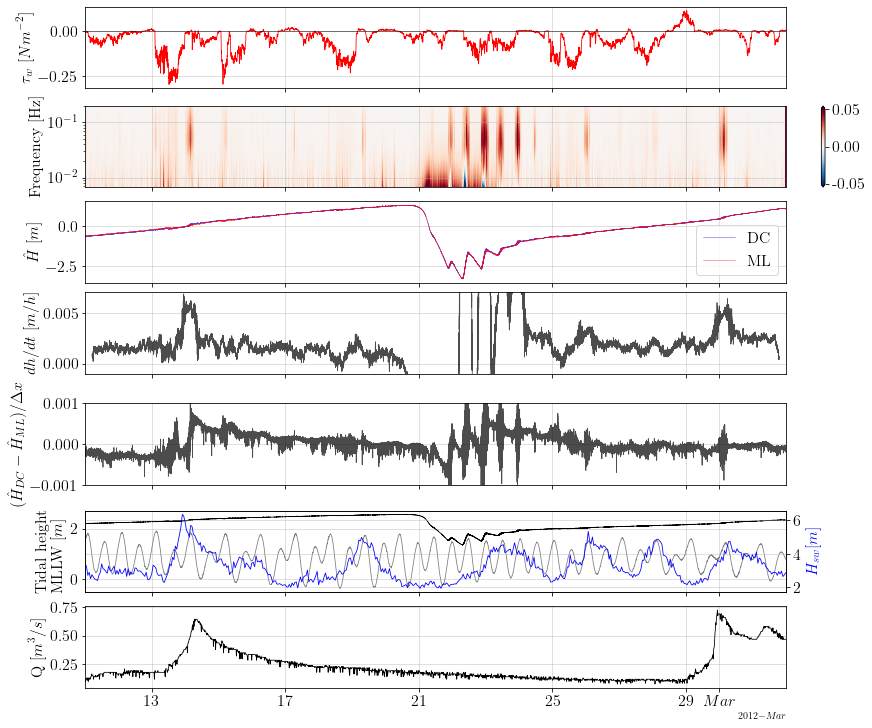

In [42]:
# #Ajustar limites colorbar
# umin = -0.1
# umax = 0.1
# vmin = -0.1
# vmax = 0.1
# level_boundaries_u = np.linspace(umin, umax, 400)
# level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax2, ax8, ax5, ax3, ax4, ax7, ax10) = plt.subplots(nrows=7, figsize=(12, 10), constrained_layout=True, sharex=True)


#Grafico velocidad viento

ax2.set_ylabel(r"$\tau_{w}$ "
          r"$\displaystyle[Nm^{-2}]$",
          fontsize=16)
ax2.plot(wdf.index, wdf.values,color='r', linewidth=0.8)
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)
# ax2.text(datetime.datetime(2012,3,2,7,30,0), 0.07, "A",
#           fontsize=16)


ax5.plot(dc.time, standardize(dc.sel(sensor=1, variables='Depth')), c='b', linewidth=0.5, label="DC", alpha=0.7)
# ax5.plot(standardize(nm.sel(sensor=1, variables='Depth').dropna("time")).time, standardize(nm.sel(sensor=1, variables='Depth').dropna("time")), c='r', linewidth=0.5, label="NM", alpha=0.7)
ax5.plot(standardize(ml.sel(sensor=1, variables='Depth').dropna("time")).time, standardize(ml.sel(sensor=1, variables='Depth').dropna("time")), c='r', linewidth=0.5, label="ML", alpha=0.7)

ax5.set_ylabel(r"$\hat{H}$ "
          r"$\displaystyle[m]$",
          fontsize=16)
ax5.xaxis.set_tick_params(labelsize=16)
ax5.yaxis.set_tick_params(labelsize=16)
ax5.grid(alpha=0.5)
ax5.legend(loc='lower right',
          fontsize=16);


#dhdt
ax3.set_ylabel(r"$dh/dt$ "
          r"$\displaystyle[m/h]$",
          fontsize=16)
ax3.plot(dc.time.values[1800:-1800], dhdt, color='k', lw=0.8, alpha=0.7)
# ax3.axhline(y=0, color='k', linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.grid(alpha=0.5)
ax3.set_ylim(-0.001, 0.007)

#NM-DC
ax4.set_ylabel(r"$(\hat{H}_{DC}-\hat{H}_{ML})/\Delta x$ ",
          fontsize=16)
ax4.plot(z_dcml.time, z_dcml/x_ml_dc, color='k', lw=0.8, alpha=0.7)
# ax3.axhline(y=0, color='k', linewidth=0.5)
ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)
ax4.grid(alpha=0.5)
ax4.set_ylim(-0.001, 0.001)

# Grafico nivel del agua SF
ax7.set_ylabel(r"\noindent Tidal height\\MLLW "
          r"$\displaystyle[m]$",
          fontsize=16)
ax7.plot(sf.index, sf.values, c='gray', lw=0.8, label="San Fco")
ax7.plot(dc.time, dc.sel(sensor=1, variables='Depth')-0.1423, c='k', linewidth=0.8, label="Pescadero")
# ax7.plot(mt.index, mt.values, c='g')
# ax7.legend(["San Fco", "Monterrey"], loc='upper right',
#           fontsize=16);
ax7.xaxis.set_tick_params(labelsize=16)
ax7.yaxis.set_tick_params(labelsize=16)
ax7.grid(alpha=0.5)

#Ajustar limites colorbar
umin = -0.05
umax = 0.05
vmin = -0.05
vmax = 0.05
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

# Grafico water level estandarizada

ax6 = ax7.twinx()
ax6.set_ylabel(r"$H_{sw}[m]$",
          fontsize=16)
ax6.plot(hm.index, hm['WVHT'].values, c='b', linewidth=0.8)
ax6.xaxis.set_tick_params(labelsize=16)
ax6.yaxis.set_tick_params(labelsize=16)
ax6.grid(alpha=0.5)
# ax6.text(datetime.datetime(2012,3,2,7,30,0), 5.5, "E",
#           fontsize=16)
ax6.yaxis.set_major_locator(tick.MultipleLocator(2))
ax6.yaxis.label.set_color("blue")

#Grafico de velocidad del agua (color map)
# ax8.set_title(r"Wavelet analysis",
#           fontsize=16)
contourf_ = ax8.contourf(dc1.index, freqs,
                         coef,
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax8, pad=0.001)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
cbar.ax.yaxis.set_major_locator(tick.MultipleLocator(0.05))
ax8.set_ylabel(r"Frequency [Hz] ",
          fontsize=16)
ax8.grid(alpha=0.5)
#    ax1.set_ylim(1, 2.5)
ax8.xaxis.set_tick_params(labelsize=16)
ax8.yaxis.set_tick_params(labelsize=16)
ax8.set_yscale("log") 
# ax8.text(datetime.datetime(2012,3,2,7,30,0), 0.1, "F",
#           fontsize=16)

# ax1.plot(dc.time, dc.sel(variables="Depth", sensor=1))
ax10.set_ylabel(r"Q "
          r"$\displaystyle[m^3/s]$",
          fontsize=16)
ax10.plot(q.index, q, lw=0.8, c='k')

ax10.xaxis.set_tick_params(labelsize=16)
ax10.yaxis.set_tick_params(labelsize=16)
ax10.grid(alpha=0.5)
# ax10.text(datetime.datetime(2012,3,2,7,30,0), 0.63, "G",
#           fontsize=16)

# Ajustar formato fecha
ax8.xaxis.set_major_locator(locator)
ax8.xaxis.set_major_formatter(formatter)

# Ajustar formato fecha
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

plt.show() 

__Feb 17th to Feb 21st__


In [41]:
bu2 = UV_burst.sel(time=slice("2012-02-17 00:00:00","2012-02-20 00:00:00")).u
wdf = dfw['u'].loc[datetime.date(2012,2,17):datetime.date(2012,2,20)]
sf = snfco.loc[datetime.date(2012,2,17):datetime.date(2012,2,20)]
hm = hmoon.loc[datetime.date(2012,2,17):datetime.date(2012,2,20)]
mt = mnty.loc[datetime.date(2012,2,17):datetime.date(2012,2,20)]
q = Q.loc[datetime.date(2012,2,17):datetime.date(2012,2,20)]

dc1 = DC_1.loc[datetime.date(2012,2,17):datetime.date(2012,2,20)]
dc2 = DC_2.loc[datetime.date(2012,2,17):datetime.date(2012,2,20)]
dc3 = DC_3.loc[datetime.date(2012,2,17):datetime.date(2012,2,20)]
dc4 = DC_4.loc[datetime.date(2012,2,17):datetime.date(2012,2,20)]

nm1 = NM_1.loc[datetime.date(2012,2,17):datetime.date(2012,2,20)]
nm2 = NM_2.loc[datetime.date(2012,2,17):datetime.date(2012,2,20)]
nm3 = NM_3.loc[datetime.date(2012,2,17):datetime.date(2012,2,20)]

ml1 = ML_1.loc[datetime.date(2012,2,17):datetime.date(2012,2,20)]
ml2 = ML_2.loc[datetime.date(2012,2,17):datetime.date(2012,2,20)]

pc1 = PC_1.loc[datetime.date(2012,2,17):datetime.date(2012,2,20)]

dc = DC_CTD.interpolate_na(dim="time", method="nearest").sel(time=slice("2012-02-17 00:00:00","2012-02-20 00:00:00")).v
nm = NM_CTD.sel(time=slice("2012-02-17 00:00:00","2012-02-20 00:00:00")).v
ml = ML_CTD.sel(time=slice("2012-02-17 00:00:00","2012-02-20 00:00:00")).v
pc = PC_CTD.sel(time=slice("2012-02-17 00:00:00","2012-02-20 00:00:00")).v

In [47]:
#Función wavelet

t = dc1.index
sig  = dc1['Depth'].values
widths = np.arange(1,41)
coef, freqs = pywt.cwt(sig, widths, 'gaus1')

#dh/dt

hf = dc.sel(sensor=1, variables='Depth').values[720:]
hi = dc.sel(sensor=1, variables='Depth').values[:-720]
dt = 2

dhdt = (hf-hi)/dt

In [51]:
# z_dcml = standardize(dc.sel(sensor=1, variables='Depth')) - standardize(ml.sel(sensor=1, variables='Depth').dropna("time"))
z_dcml = standardize(dc.sel(sensor=1, variables='Depth')) - standardize(ml.sel(sensor=1, variables='Depth')).dropna("time")

x_ml_dc = haversine(37.264861111, -122.410527778, 37.264055556, -122.410333333) *1000 #en metros



In [52]:
dzdx = z_dcml/x_ml_dc

dzdx.rolling(time=30).mean()

<xarray.DataArray 'v' (time: 25921)>
array([            nan,             nan,             nan, ...,
       -5.07574116e-05, -8.35059558e-06,  7.27241278e-06])
Coordinates:
  * time       (time) datetime64[ns] 2012-02-17 ... 2012-02-20
    variables  <U5 'Depth'
    sensor     int64 1

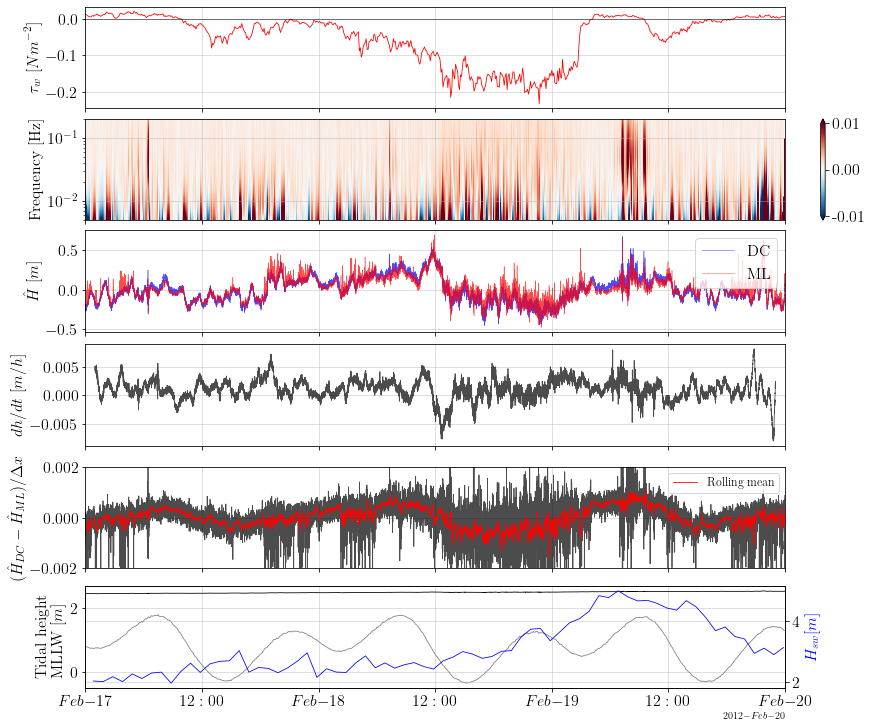

In [56]:
# #Ajustar limites colorbar
# umin = -0.1
# umax = 0.1
# vmin = -0.1
# vmax = 0.1
# level_boundaries_u = np.linspace(umin, umax, 400)
# level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax2, ax8, ax5, ax3, ax4, ax7) = plt.subplots(nrows=6, figsize=(12, 10), constrained_layout=True, sharex=True)


#Grafico velocidad viento

ax2.set_ylabel(r"$\tau_{w}$ "
          r"$\displaystyle[Nm^{-2}]$",
          fontsize=16)
ax2.plot(wdf.index, wdf.values,color='r', linewidth=0.8)
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)
# ax2.text(datetime.datetime(2012,3,2,7,30,0), 0.07, "A",
#           fontsize=16)


ax5.plot(dc.time, standardize(dc.sel(sensor=1, variables='Depth')), c='b', linewidth=0.5, label="DC", alpha=0.7)
# ax5.plot(standardize(nm.sel(sensor=1, variables='Depth').dropna("time")).time, standardize(nm.sel(sensor=1, variables='Depth').dropna("time")), c='r', linewidth=0.5, label="NM", alpha=0.7)
ax5.plot(standardize(ml.sel(sensor=1, variables='Depth').dropna("time")).time, standardize(ml.sel(sensor=1, variables='Depth').dropna("time")), c='r', linewidth=0.5, label="ML", alpha=0.7)

ax5.set_ylabel(r"$\hat{H}$ "
          r"$\displaystyle[m]$",
          fontsize=16)
ax5.xaxis.set_tick_params(labelsize=16)
ax5.yaxis.set_tick_params(labelsize=16)
ax5.grid(alpha=0.5)
ax5.legend(loc='upper right',
          fontsize=16);
# ax5.set_ylim(-1, 1)


#dhdt
ax3.set_ylabel(r"$dh/dt$ "
          r"$\displaystyle[m/h]$",
          fontsize=16)
ax3.plot(dc.time.values[360:-360], dhdt, color='k', lw=0.8, alpha=0.7)
# ax3.axhline(y=0, color='k', linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.grid(alpha=0.5)
# ax3.set_ylim(-0.001, 0.007)

#NM-DC
ax4.set_ylabel(r"$(\hat{H}_{DC}-\hat{H}_{ML})/\Delta x$ ",
          fontsize=16)
ax4.plot(z_dcml.time, z_dcml/x_ml_dc, color='k', lw=0.8, alpha=0.7)
ax4.plot(z_dcml.time, dzdx.rolling(time=30).mean(), color='r', lw=0.8, alpha=1, label="Rolling mean")
# ax3.axhline(y=0, color='k', linewidth=0.5)
ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)
ax4.grid(alpha=0.5)
ax4.set_ylim(-0.002, 0.002)
ax4.legend(loc='upper right',
          fontsize=12);

# Grafico nivel del agua SF
ax7.set_ylabel(r"\noindent Tidal height\\MLLW "
          r"$\displaystyle[m]$",
          fontsize=16)
ax7.plot(sf.index, sf.values, c='gray', lw=0.8, label="San Fco")
ax7.plot(dc.time, dc.sel(sensor=1, variables='Depth')-0.1423, c='k', linewidth=0.8, label="Pescadero")
# ax7.plot(mt.index, mt.values, c='g')
# ax7.legend(["San Fco", "Monterrey"], loc='upper right',
#           fontsize=16);
ax7.xaxis.set_tick_params(labelsize=16)
ax7.yaxis.set_tick_params(labelsize=16)
ax7.grid(alpha=0.5)

#Ajustar limites colorbar
umin = -0.01
umax = 0.01
vmin = -0.05
vmax = 0.05
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

# Grafico water level estandarizada

ax6 = ax7.twinx()
ax6.set_ylabel(r"$H_{sw}[m]$",
          fontsize=16)
ax6.plot(hm.index, hm['WVHT'].values, c='b', linewidth=0.8)
ax6.xaxis.set_tick_params(labelsize=16)
ax6.yaxis.set_tick_params(labelsize=16)
ax6.grid(alpha=0.5)
# ax6.text(datetime.datetime(2012,3,2,7,30,0), 5.5, "E",
#           fontsize=16)
ax6.yaxis.set_major_locator(tick.MultipleLocator(2))
ax6.yaxis.label.set_color("blue")

#Grafico de velocidad del agua (color map)
# ax8.set_title(r"Wavelet analysis",
#           fontsize=16)
contourf_ = ax8.contourf(dc1.index, freqs,
                         coef,
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax8, pad=0.001)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
cbar.ax.yaxis.set_major_locator(tick.MultipleLocator(0.01))
ax8.set_ylabel(r"Frequency [Hz] ",
          fontsize=16)
ax8.grid(alpha=0.5)
#    ax1.set_ylim(1, 2.5)
ax8.xaxis.set_tick_params(labelsize=16)
ax8.yaxis.set_tick_params(labelsize=16)
ax8.set_yscale("log") 
# ax8.text(datetime.datetime(2012,3,2,7,30,0), 0.1, "F",
#           fontsize=16)

# Ajustar formato fecha
ax8.xaxis.set_major_locator(locator)
ax8.xaxis.set_major_formatter(formatter)

# Ajustar formato fecha
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

plt.show() 

In [49]:
#Función wavelet

t = dc1.index
sig  = dc1['Depth'].values
widths = np.arange(1,200)
coef, freqs = pywt.cwt(sig, widths, 'gaus1')

#dh/dt

hf = dc.sel(sensor=1, variables='Depth').values[3600:]
hi = dc.sel(sensor=1, variables='Depth').values[:-3600]
dt = 10

dhdt = (hf-hi)/dt

NameError: name 'level_boundaries_u' is not defined

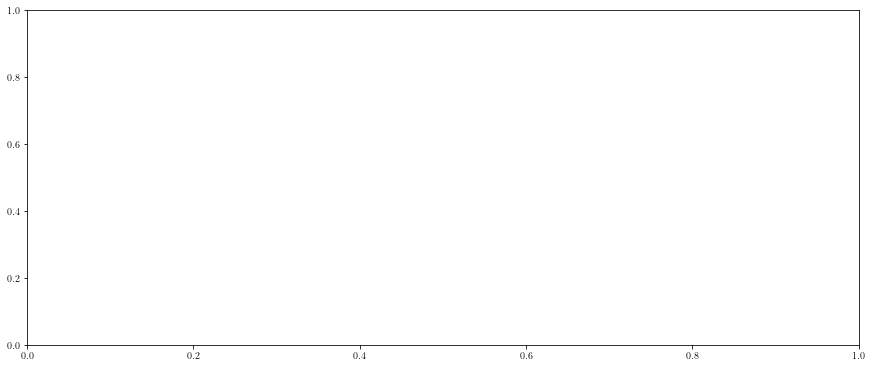

In [44]:
fig, (ax8) = plt.subplots(nrows=1, figsize=(12, 5), constrained_layout=True, sharex=True)

#Ajustar limites colorbar
umin = -0.01
umax = 0.01
vmin = -0.05
vmax = 0.05
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

contourf_ = ax8.contourf(dc1.index, freqs,
                         coef,
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax8, pad=0.001)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
cbar.ax.yaxis.set_major_locator(tick.MultipleLocator(0.05))
ax8.set_ylabel(r"Frequency [Hz] ",
          fontsize=16)
ax8.grid(alpha=0.5)
#    ax1.set_ylim(1, 2.5)
ax8.xaxis.set_tick_params(labelsize=16)
ax8.yaxis.set_tick_params(labelsize=16)
ax8.set_yscale("log") 
# ax8.text(datetime.datetime(2012,3,2,7,30,0), 0.1, "F",
#           fontsize=16)

# Ajustar formato fecha
ax8.xaxis.set_major_locator(locator)
ax8.xaxis.set_major_formatter(formatter)

# Frequency analysis

__Feb 11st to Feb 20st__

In [64]:
bu2 = UV_burst.sel(time=slice("2012-02-11 00:00:00","2012-02-20 00:00:00")).u
wdf = dfw['u'].loc[datetime.date(2012,2,11):datetime.date(2012,2,20)]
sf = snfco.loc[datetime.date(2012,2,11):datetime.date(2012,2,20)]
hm = hmoon.loc[datetime.date(2012,2,11):datetime.date(2012,2,20)]
mt = mnty.loc[datetime.date(2012,2,11):datetime.date(2012,2,20)]
q = Q.loc[datetime.date(2012,2,11):datetime.date(2012,2,20)]

dc1 = DC_1.loc[datetime.date(2012,2,11):datetime.date(2012,2,20)]
dc2 = DC_2.loc[datetime.date(2012,2,11):datetime.date(2012,2,20)]
dc3 = DC_3.loc[datetime.date(2012,2,11):datetime.date(2012,2,20)]
dc4 = DC_4.loc[datetime.date(2012,2,11):datetime.date(2012,2,20)]

nm1 = NM_1.loc[datetime.date(2012,2,11):datetime.date(2012,2,20)]
nm2 = NM_2.loc[datetime.date(2012,2,11):datetime.date(2012,2,20)]
nm3 = NM_3.loc[datetime.date(2012,2,11):datetime.date(2012,2,20)]

ml1 = ML_1.loc[datetime.date(2012,2,11):datetime.date(2012,2,20)]
ml2 = ML_2.loc[datetime.date(2012,2,11):datetime.date(2012,2,20)]

pc1 = PC_1.loc[datetime.date(2012,2,11):datetime.date(2012,2,20)]

dc = DC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-20 00:00:00")).v
nm = NM_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-20 00:00:00")).v
ml = ML_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-20 00:00:00")).v
pc = PC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-20 00:00:00")).v

C:\Users\Dhannai\AppData\Local\Temp\ipykernel_8260\1416135434.py:58: RuntimeWarning: divide by zero encountered in reciprocal
  return (x * 60) ** (-1)


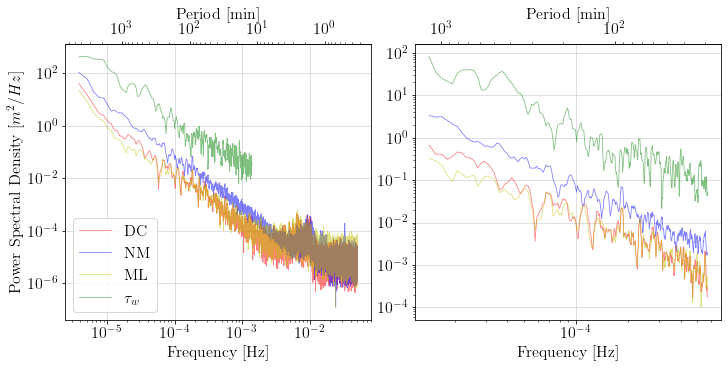

In [66]:
# h_dc = dc.sel(sensor=1, variables='Depth') - dc.sel(sensor=1, variables='Depth').mean()
# h_nm = nm.sel(sensor=1, variables='Depth') - nm.sel(sensor=1, variables='Depth').mean()
# h_ml = ml.sel(sensor=1, variables='Depth') - ml.sel(sensor=1, variables='Depth').mean()
h_ml = ml1['Depth'] - ml1['Depth'].mean()
h_nm = nm1['Depth'] - nm1['Depth'].mean()
h_dc = dc1['Depth'] - dc1['Depth'].mean()
# h_sf = sf['Verified (m)'] - sf['Verified (m)'].mean()
h_wdf = wdf.values - wdf.values.mean()
    
freqs1, ps1, psd1 = spectrum4(h_dc, dt=10)
freqs2, ps2, psd2 = spectrum4(h_nm, dt=10)
freqs3, ps3, psd3 = spectrum4(h_ml, dt=10)
# freqs4, ps4, psd4 = spectrum4(h_ml, dt=10)
# freqs5, ps5, psd5 = spectrum4(h_pc, dt=30)
freqs6, ps6, psd6 = spectrum4(h_wdf, dt=360)

fig, axs = plt.subplots(ncols=2, figsize=(10, 5), constrained_layout=True)
axs[0].loglog(freqs1, psd1, 'r', alpha=0.5, linewidth=0.8, label='DC')
axs[0].loglog(freqs2, psd2, 'b', alpha=0.5, linewidth=0.8, label='NM')
axs[0].loglog(freqs3, psd3, 'y', alpha=0.5, linewidth=0.8, label='ML')
axs[0].loglog(freqs6, psd6, 'g', alpha=0.5, linewidth=0.8, label=r"$\tau_{w}$")
# axs[0].loglog(freqs4, psd4, 'c', alpha=0.5, linewidth=0.8, label='ML')
# axs[0].loglog(freqs5, psd5, 'y', alpha=0.5, linewidth=0.8, label='PC')
# axs[0].axis('tight', which='x')
axs[0].legend(loc='lower left',
          fontsize=16)

i0, i1 = np.searchsorted(freqs1, [1.31969058e-05, 5.70464135e-04])
i04, i14 = np.searchsorted(freqs3, [1.31969058e-04, 9.70464135e-03])
sl = slice(i0, i1)
sl4 = slice(i04, i14)
axs[1].loglog(freqs1[sl], psd1[sl], 'r', 
              freqs2[sl], psd2[sl], 'b', 
              freqs3[sl], psd3[sl], 'y', 
              freqs6[sl], psd6[sl], 'g', alpha=0.5, linewidth=0.8)
#axs[1].axis('tight', which='x')
axs[0].set_ylabel('Power Spectral Density [$m^2/Hz$]',
          fontsize=16)
axs[0].set_xlabel('Frequency [Hz]',
          fontsize=16)
axs[1].set_xlabel('Frequency [Hz]',
          fontsize=16)
axs[0].xaxis.set_tick_params(labelsize=16)
axs[0].yaxis.set_tick_params(labelsize=16)
axs[1].xaxis.set_tick_params(labelsize=16)
axs[1].yaxis.set_tick_params(labelsize=16)
axs[0].grid(alpha=0.5)
axs[1].grid(alpha=0.5)


def freq2period(x):
    x = x.astype(float)
    return x ** (-1) / 60


def period2freq(x):
    x = x.astype(float)
    return (x * 60) ** (-1)

secax0 = axs[0].secondary_xaxis('top', functions=(freq2period, period2freq))
secax0.set_xlabel('Period [min]',
          fontsize=16)
secax1 = axs[1].secondary_xaxis('top', functions=(freq2period, period2freq))
secax1.set_xlabel('Period [min]',
          fontsize=16)
secax0.xaxis.set_tick_params(labelsize=16)
secax0.yaxis.set_tick_params(labelsize=16)
secax1.xaxis.set_tick_params(labelsize=16)
secax1.yaxis.set_tick_params(labelsize=16)
secax0.grid(alpha=0.5)
secax1.grid(alpha=0.5)

plt.show()